# Speech Recognition for Multiple Languages using Deep Learning

> This project explores the task of speech recognition for multiple languages using deep learning techniques. The dataset employed consists of audio files representing various languages.

## Dataset Source

The dataset used in this project is a subset of the larger dataset available on GitHub:

* **GitHub repo:** [Spoken Language Dataset](https://github.com/tomasz-oponowicz/spoken-language_dataset?tab=readme-ov-file) by Tomasz Oponowicz

A pre-processed subset of this dataset, tailored for this project, is available on Google Drive:

* **Google Drive:** [MyDrive](https://drive.google.com/drive/folders/1_xQUO-yui_V8RbEm6Ugz6q5AD0rH0Mah?usp=sharing)

Please note that the Google Drive link is used to download the dataset.

## Dataset Structure

> The dataset contains training and testing audio files. The language of each audio file is indicated by the first two letters of the filename.

> You can refer to '**Feature Extraction from audio file**' through this [link](https://colab.research.google.com/drive/1LEnGaHyZush57tUEoKI8c9RNSclUYkUr?usp=sharing).

> If you want to use the saved model for inference then use this [link](https://colab.research.google.com/drive/1h4NAWyvdK6pO7YmH8rPwypeTsGFBtJTm?usp=drive_link) to **'Speech Recognition Inference'** file.

## 1. Mount Google Drive and Install Dependencies

**Google Drive Mounting:** Allows accessing data and saving models directly in Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Import Libraries

Libraries for:
  * File handling (os).
  * Numerical operations (numpy).
  * Audio processing (librosa).
  * Splitting data and metrics (sklearn).
  * Deep learning models (tensorflow.keras).
  * Visualization (matplotlib, seaborn).

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Set Path Variables
* Defines paths for data storage and model saving.
* Ensures the folder for saving models exists.


In [ ]:
DRIVE_PATH = '/content/drive/My Drive/Language_Dataset'
TRAIN_PATH = os.path.join(DRIVE_PATH, 'train')
TEST_PATH = os.path.join(DRIVE_PATH, 'test')
MODEL_SAVE_PATH = os.path.join('/content/drive/My Drive/Language_Detection', 'models01')

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

## 4. Data Loading and Processing Functions

1. `load_data`:
Reads audio files, extracts MFCC features, and creates feature-label pairs.


2. `load_and_split_data`:
Splits data into training, validation, and test sets.
Encodes labels numerically (English: 0, Spanish: 1, German: 2).


3. Returns reshaped data for further processing.

In [ ]:
def load_data(data_path, duration=10, sr=22050):
    features = []
    labels = []

    for filename in os.listdir(data_path):
        if filename.endswith('.flac'):
            label = filename[:2]
            audio_path = os.path.join(data_path, filename)
            audio, _ = librosa.load(audio_path, duration=duration, sr=sr)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfcc_scaled = np.mean(mfcc.T, axis=0)
            features.append(mfcc_scaled)
            labels.append(label)

    return np.array(features), np.array(labels)

In [ ]:
def load_and_split_data():
    train_features, train_labels = load_data(TRAIN_PATH)

    X_train, X_val, y_train, y_val = train_test_split(
        train_features,
        train_labels,
        test_size=0.2,
        random_state=42,
        stratify=train_labels
    )

    test_features, test_labels = load_data(TEST_PATH)

    label_map = {'en': 0, 'es': 1, 'de': 2}
    y_train = np.array([label_map[label] for label in y_train])
    y_val = np.array([label_map[label] for label in y_val])
    y_test = np.array([label_map[label] for label in test_labels])

    return X_train, X_val, test_features, y_train, y_val, y_test

In [ ]:
# Load and prepare data
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data()

In [ ]:
# Reshape data for different models
X_train_fnn, X_val_fnn, X_test_fnn = X_train, X_val, X_test
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## 5. Model Architectures

In [ ]:
def create_fnn_model(input_shape, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

This Python code defines a function `create_fnn_model` that constructs a feedforward neural network **(FNN) model**.

### Key Components:

* `Sequential` Model:
  * A linear stack of layers, where each layer processes the output of the previous one.
* `Dense` Layers:
  * Fully connected layers with ReLU activation, introducing non-linearity.
* `Dropout` Layers:
  * Randomly set a fraction of input units to zero during training, preventing overfitting.
* `num_classes`:
  * Specifies the number of output classes.
* `softmax` Activation:
  * Outputs a probability distribution over the num_classes.


### Model Architecture:

* Input Layer: Takes input data with the specified input_shape.
* Hidden Layers: Three hidden layers with 256, 128, and 64 neurons, respectively, using ReLU activation and dropout.
* Output Layer: A dense layer with num_classes neurons and softmax activation.


### Usage:

* Specify Input Shape: Determine the shape of your input data (e.g., (28, 28, 1) for a 28x28 grayscale image).
* Specify Number of Classes: Determine the number of classes to classify.
* Call the Function: Call create_fnn_model with the input shape and number of classes.
* Compile and Train: Compile the model with an optimizer (e.g., Adam) and a loss function (e.g., categorical cross-entropy), then train it on your dataset.

In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        tf.keras.layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        Conv1D(32, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

This Python code defines a function `create_cnn_model` that constructs a Convolutional Neural Network **(CNN) model** specifically designed for one-dimensional input data, such as time series or audio signals.

### Key Components:

1. `Reshape` Layer:
  * Reshapes the input data into a 2D format suitable for 1D convolution.

2. `Conv1D` Layers:
1D convolutional layers that extract features from the input data.
  * `filters`: Specifies the number of filters (kernels) to apply.
  * `kernel_size`: Specifies the size of the filter.
  * `activation`='relu': Applies the ReLU activation function.
  * `padding='same'`: Preserves the input sequence length after convolution.

3. `MaxPooling1D` Layers:

  * Downsamples the feature maps by taking the maximum value within a specific window size, reducing dimensionality and capturing essential features.

4. `Flatten` Layer:

  * Flattens the 2D feature maps into a 1D array, preparing the data for the dense layers.

5. Dense Layers:

  * Fully connected layers with ReLU activation, similar to the FNN model.
  * The final dense layer uses softmax activation to output probabilities for each class.


### Model Architecture:

* Input Layer:
  * Takes one-dimensional input data with the specified input_shape.
* Convolutional Layers:
  * Three 1D convolutional layers extract features from the input data.
  * Max pooling layers reduce dimensionality and capture important features.
* Flattening Layer:
  * Flattens the output of the convolutional layers.
* Dense Layers:
  * A dense layer with 128 neurons and ReLU activation.
  * A final dense layer with num_classes neurons and softmax activation.

### Usage:

* Specify Input Shape: Determine the shape of your one-dimensional input data (e.g., (100, 1) for a sequence of 100 time steps).
* Specify Number of Classes: Determine the number of classes to classify.
* Call the Function: Call create_cnn_model with the input shape and number of classes.
* Compile and Train: Compile the model with an optimizer (e.g., Adam) and a loss function (e.g., categorical cross-entropy), then train it on your dataset.

In [ ]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        tf.keras.layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        Conv1D(32, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(2),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

This Python code defines a function `create_cnn_lstm_model` that constructs a hybrid neural network model combining **Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks**. This model is particularly effective for handling sequential data, such as time series or audio signals.

### Key Components:

1. `Reshape` Layer:
  * Reshapes the input data into a 2D format suitable for 1D convolution.
Conv1D Layers:

  * 1D convolutional layers extract local features from the input data.

2. `MaxPooling1D` Layers:
  * Downsample the feature maps, reducing dimensionality and capturing important features.

3. `LSTM` Layers:

  * LSTM layers capture long-range dependencies in the sequential data.
return_sequences=True: The first LSTM layer returns the full sequence of outputs.
  *The second LSTM layer processes the output of the first LSTM layer.

4. `Dense` Layers:

  * Fully connected layers with ReLU activation, similar to the FNN model.
  * The final dense layer uses softmax activation to output probabilities for each class.

### Model Architecture:

* Input Layer: Takes one-dimensional input data with the specified input_shape.
* Convolutional Layers: Extract local features from the input data.
* LSTM Layers: Capture long-range dependencies in the sequential data.
* Dense Layers: Classify the input data into one of num_classes.

### Usage:

* Specify Input Shape: Determine the shape of your one-dimensional input data.
* Specify Number of Classes: Determine the number of classes to classify.
* Call the Function: Call create_cnn_lstm_model with the input shape and number of classes.
* Compile and Train: Compile the model with an optimizer (e.g., Adam) and a loss function (e.g., categorical cross-entropy), then train it on your dataset.

## 6. Training and Evaluation Functions

* `train_and_evaluate`:
Compiles the model, trains it, evaluates on test data, and saves the model.

* `plot_metrics`:
Visualizes accuracy trends during training and validation.

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name, epochs=50, batch_size=32):
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=epochs,
                       batch_size=batch_size)

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

    save_model(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}.h5'))
    return history

In [ ]:
def plot_metrics(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

## 7. Train and Evaluate FNN Model

In [ ]:
fnn_model = create_fnn_model((X_train.shape[1],), 3)
fnn_history = train_and_evaluate(fnn_model,
                               X_train_fnn, y_train,
                               X_val_fnn, y_val,
                               X_test_fnn, y_test,
                               'FNN')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.3334 - loss: 7.3966 - val_accuracy: 0.3330 - val_loss: 1.1869
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3487 - loss: 1.5015 - val_accuracy: 0.2868 - val_loss: 1.1036
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3260 - loss: 1.1944 - val_accuracy: 0.3580 - val_loss: 1.0946
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3346 - loss: 1.1270 - val_accuracy: 0.3330 - val_loss: 1.1027
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3357 - loss: 1.1197 - val_accuracy: 0.3497 - val_loss: 1.0974
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3350 - loss: 1.1056 - val_accuracy: 0.3645 - val_loss: 1.0953
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3360 - loss: 1.1099 - val_accuracy: 0.3515 - val_loss: 1.0950
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3442 - loss: 1.1040 - val_accuracy: 0


Test Set Accuracy: 0.5463


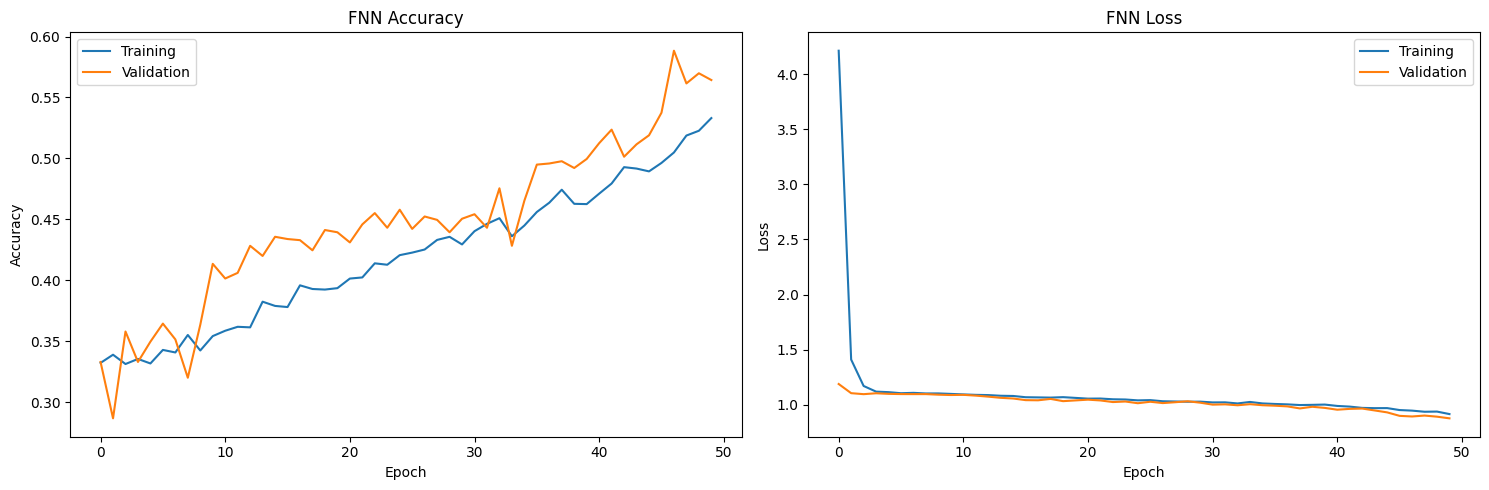

In [ ]:
plot_metrics(fnn_history, 'FNN')

In [ ]:
y_pred = fnn_model.predict(X_test_fnn)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nFNN Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['English', 'Spanish', 'German']))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

FNN Classification Report:
              precision    recall  f1-score   support

     English       0.00      0.00      0.00       180
     Spanish       0.45      0.70      0.54       180
      German       0.84      0.94      0.89       180

    accuracy                           0.55       540
   macro avg       0.43      0.55      0.48       540
weighted avg       0.43      0.55      0.48       540



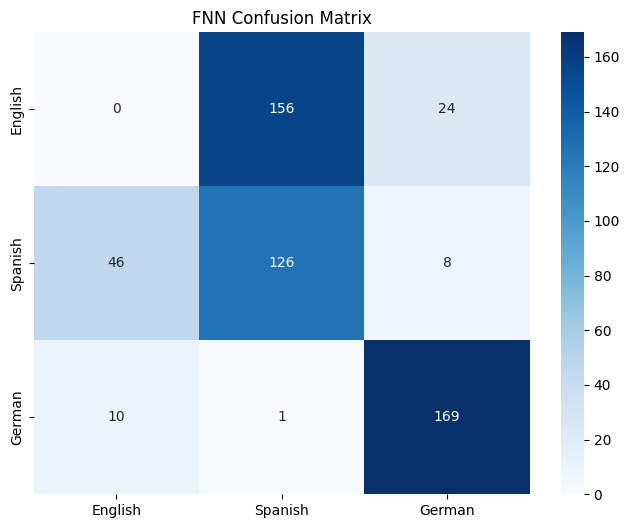

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['English', 'Spanish', 'German'],
           yticklabels=['English', 'Spanish', 'German'])
plt.title('FNN Confusion Matrix')
plt.show()

## 8. Train and Evaluate CNN Model

In [ ]:
cnn_model = create_cnn_model((X_train.shape[1],), 3)
cnn_history = train_and_evaluate(cnn_model,
                               X_train_cnn, y_train,
                               X_val_cnn, y_val,
                               X_test_cnn, y_test,
                               'CNN')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.3615 - loss: 4.2993 - val_accuracy: 0.4598 - val_loss: 1.0485
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4223 - loss: 1.0771 - val_accuracy: 0.4931 - val_loss: 1.0157
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4371 - loss: 1.0476 - val_accuracy: 0.5273 - val_loss: 0.9846
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5066 - loss: 0.9921 - val_accuracy: 0.5338 - val_loss: 0.9442
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5410 - loss: 0.9461 - val_accuracy: 0.5513 - val_loss: 0.9015
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5112 - loss: 0.9611 - val_accuracy: 0.5652 - val_loss: 0.8996
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5700 - loss: 0.8922 - val_accuracy: 0.5513 - val_loss: 0.9277
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5649 - loss: 0.8826 - val_accuracy: 0.6411 - val


Test Set Accuracy: 0.7426


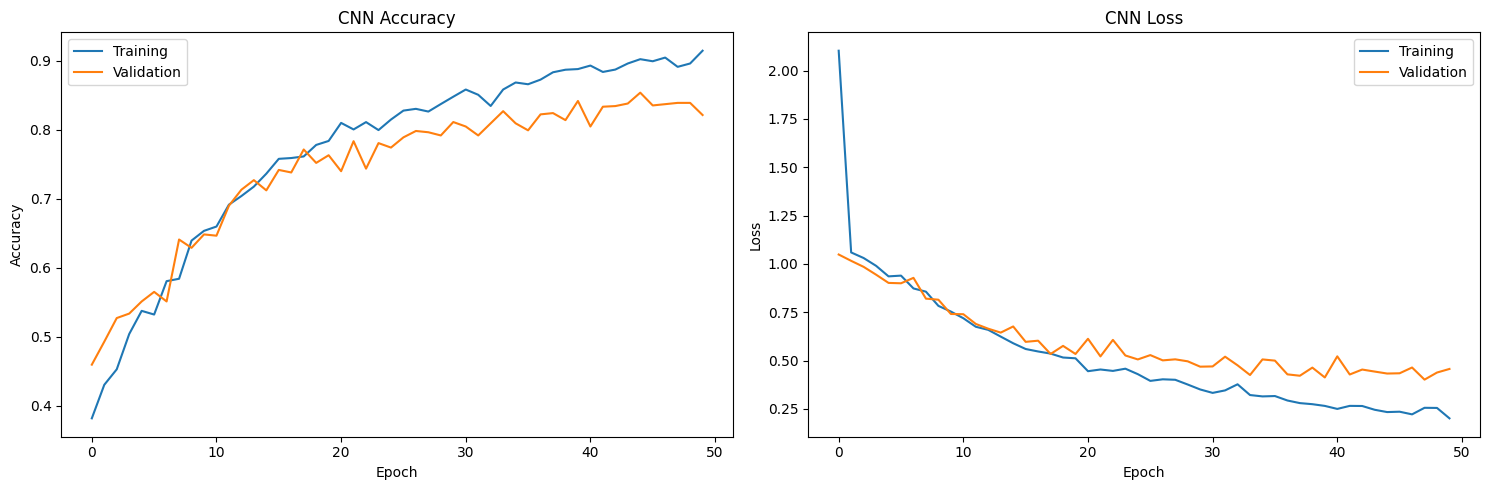

In [ ]:
plot_metrics(cnn_history, 'CNN')

In [ ]:
y_pred = cnn_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nCNN Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['English', 'Spanish', 'German']))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

CNN Classification Report:
              precision    recall  f1-score   support

     English       0.62      0.79      0.70       180
     Spanish       0.79      0.80      0.79       180
      German       0.89      0.64      0.74       180

    accuracy                           0.74       540
   macro avg       0.77      0.74      0.74       540
weighted avg       0.77      0.74      0.74       540



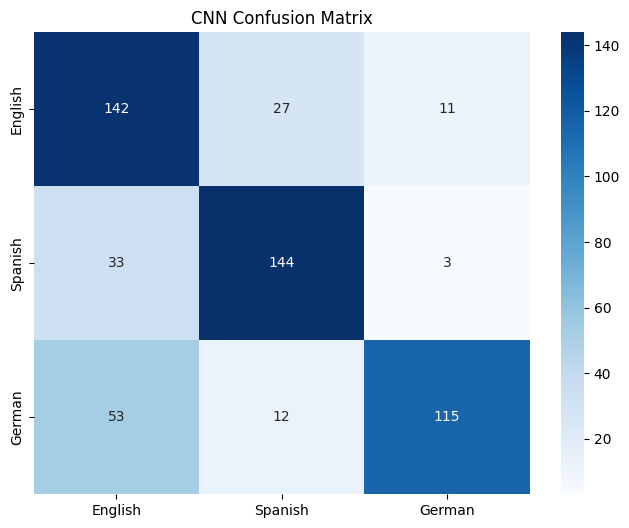

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['English', 'Spanish', 'German'],
           yticklabels=['English', 'Spanish', 'German'])
plt.title('CNN Confusion Matrix')
plt.show()

## 9. Train and Evaluate CNN-LSTM Model

In [ ]:
cnn_lstm_model = create_cnn_lstm_model((X_train.shape[1],), 3)
cnn_lstm_history = train_and_evaluate(cnn_lstm_model,
                                    X_train_cnn, y_train,
                                    X_val_cnn, y_val,
                                    X_test_cnn, y_test,
                                    'CNN_LSTM')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3630 - loss: 1.0927 - val_accuracy: 0.4635 - val_loss: 1.0208
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4982 - loss: 0.9955 - val_accuracy: 0.5245 - val_loss: 0.9394
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5663 - loss: 0.8993 - val_accuracy: 0.6004 - val_loss: 0.8370
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6330 - loss: 0.7933 - val_accuracy: 0.6540 - val_loss: 0.7429
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6689 - loss: 0.7083 - val_accuracy: 0.6994 - val_loss: 0.6686
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7155 - loss: 0.6357 - val_accuracy: 0.7123 - val_loss: 0.6385
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7181 - loss: 0.6252 - val_accuracy: 0.7114 - val_loss: 0.6543
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7399 - loss: 0.5741 - val_accuracy: 0.7586 - va


Test Set Accuracy: 0.6759


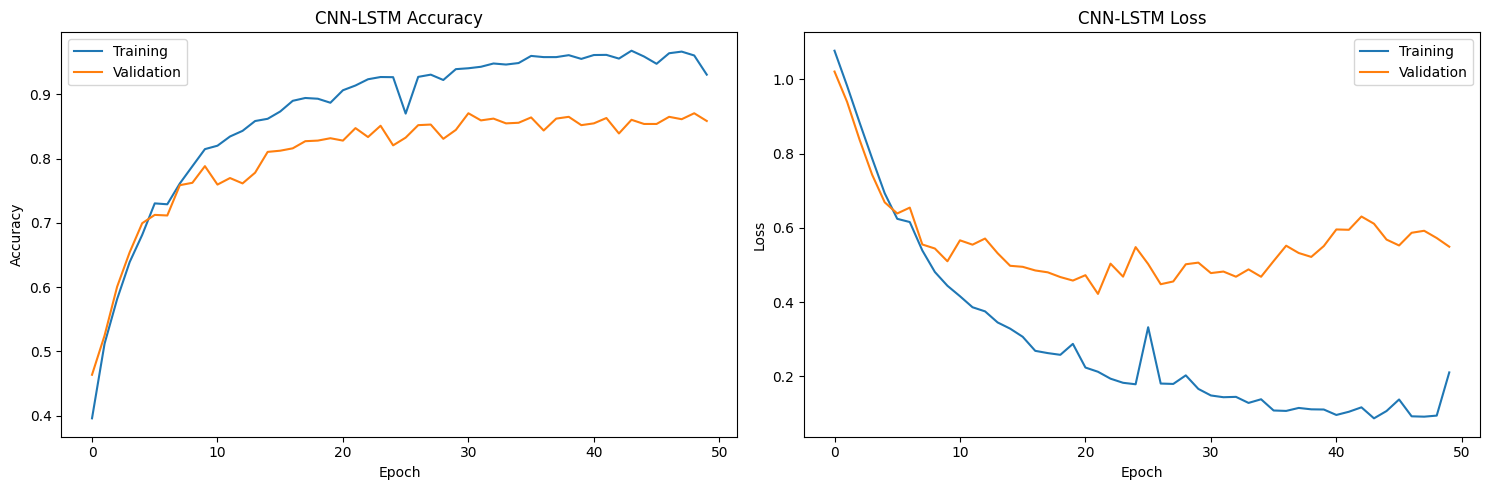

In [ ]:
plot_metrics(cnn_lstm_history, 'CNN-LSTM')

In [ ]:
y_pred = cnn_lstm_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nCNN-LSTM Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['English', 'Spanish', 'German']))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

CNN-LSTM Classification Report:
              precision    recall  f1-score   support

     English       0.66      0.82      0.73       180
     Spanish       0.77      0.60      0.67       180
      German       0.63      0.61      0.62       180

    accuracy                           0.68       540
   macro avg       0.68      0.68      0.67       540
weighted avg       0.68      0.68      0.67       540



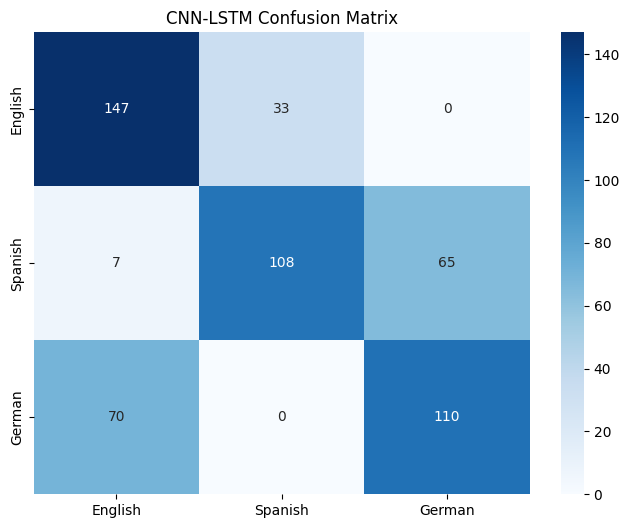

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['English', 'Spanish', 'German'],
           yticklabels=['English', 'Spanish', 'German'])
plt.title('CNN-LSTM Confusion Matrix')
plt.show()

## 10. Comparison of Train and Test Accuracies

In [ ]:
# Collect train and test accuracies
model_accuracies = {
    'FNN': {
        'train': fnn_history.history['accuracy'][-1],  # Last epoch's train accuracy
        'test': fnn_model.evaluate(X_test_fnn, y_test, verbose=0)[1]  # Test accuracy
    },
    'CNN': {
        'train': cnn_history.history['accuracy'][-1],
        'test': cnn_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
    },
    'CNN-LSTM': {
        'train': cnn_lstm_history.history['accuracy'][-1],
        'test': cnn_lstm_model.evaluate(X_test_cnn, y_test, verbose=0)[1]
    }
}

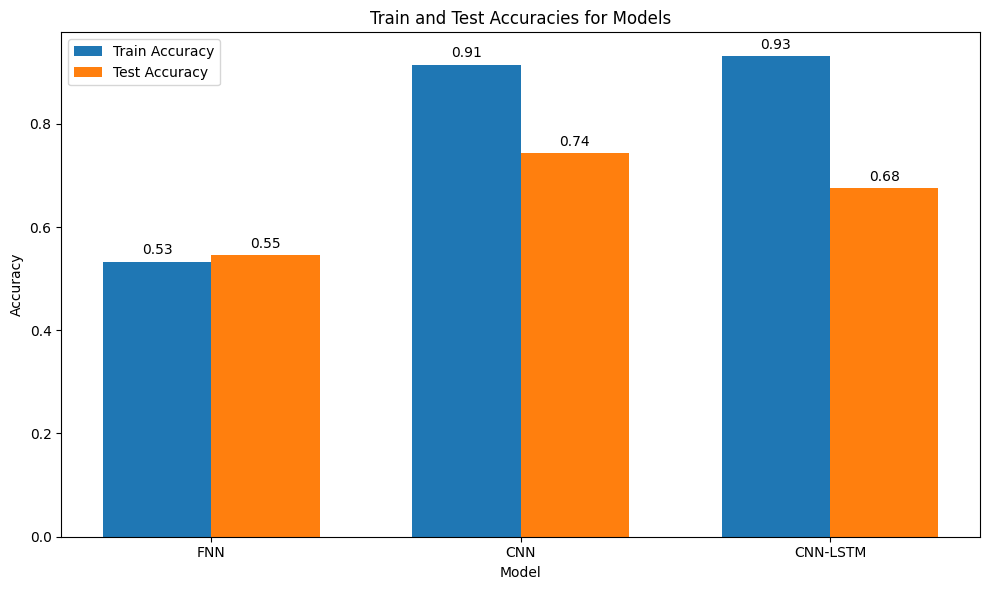

In [ ]:
# Plotting bar graph
labels = list(model_accuracies.keys())
train_accuracies = [model_accuracies[model]['train'] for model in labels]
test_accuracies = [model_accuracies[model]['test'] for model in labels]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
bars2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Accuracies for Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars with accuracy values
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Observation
1.	The CNN model outperformed the other architectures on the test set, achieving a test accuracy of 74.7%. Its convolutional layers effectively captured spatial features in the MFCC spectrograms.

2.	The CNN + LSTM model achieved the highest training accuracy (93.7%) but underperformed on the test set (68.4%) due to overfitting, likely caused by its higher complexity and parameter count.

3.	The FNN model performed the worst, with a test accuracy of only 55.8%, as it lacked the capability to capture spatial and temporal relationships in the data.
